In [1]:
# Frequency bands
BROADBAND = (0.0, 150.0)
DELTA = (0.0, 4.0)
THETA = (4.0, 8.0)
ALPHA = (8.0, 13.0)
BETA = (13.0, 30.0)
GAMMA = (30.0, 50.0)
HIGH_GAMMA = (50.0, 150.0)

# Parameters 
DATA_PATH = "Data/Aperiodic_signals"
DATASET_1 = 1  
DATASET_2 = 2

# Import Dependencies

In [2]:
import os
import re
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from tqdm import tqdm

# To plot
import seaborn as sns
sns.set_theme(style="darkgrid")
from matplotlib import pyplot as plt

# For ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Import and PreProcess PSD data

In [32]:
# Import information Data : ROIs, Freq and IDs
ROIs = list(pd.read_csv(os.path.join(DATA_PATH, "ROIs.csv")).columns)
Freqs = list(pd.read_csv(os.path.join(DATA_PATH, "Frequency_used_aperiodic_corr_spectra.csv")).columns)
IDs = list(pd.read_csv(os.path.join(DATA_PATH, "subject_codes.csv"))["Ids"])

columns = np.concatenate([[roi + "_" + str(round(float(freq), 2)) for freq in Freqs] for roi in ROIs])


# Import recordings
record_1 = pd.read_csv(os.path.join(DATA_PATH, "record_1.csv"), names=columns)
record_1["Subject_ID"] = IDs
record_1.set_index("Subject_ID", inplace = True)

record_2 = pd.read_csv(os.path.join(DATA_PATH, "record_2.csv"), names=columns)
record_2["Subject_ID"] = IDs
record_2.set_index("Subject_ID", inplace = True)

record_3 = pd.read_csv(os.path.join(DATA_PATH, "record_3.csv"), names=columns)
record_3["Subject_ID"] = IDs
record_3.set_index("Subject_ID", inplace = True)

In [33]:
# Example of the data
# 89 subjects x 14652(= 148 ROI x 99 Freq)
record_1.head()

,G_Ins_lg_and_S_cent_ins L_1.0,G_Ins_lg_and_S_cent_ins L_1.5,G_Ins_lg_and_S_cent_ins L_2.0,G_Ins_lg_and_S_cent_ins L_2.5,G_Ins_lg_and_S_cent_ins L_3.0,G_Ins_lg_and_S_cent_ins L_3.5,G_Ins_lg_and_S_cent_ins L_4.0,G_Ins_lg_and_S_cent_ins L_4.5,G_Ins_lg_and_S_cent_ins L_5.0,G_Ins_lg_and_S_cent_ins L_5.5,...,S_temporal_transverse R_45.51,S_temporal_transverse R_46.01,S_temporal_transverse R_46.51,S_temporal_transverse R_47.01,S_temporal_transverse R_47.51,S_temporal_transverse R_48.01,S_temporal_transverse R_48.51,S_temporal_transverse R_49.01,S_temporal_transverse R_49.51,S_temporal_transverse R_50.01
Subject_ID,,,,,,,,,,,,,,,,,,,,,
100307,0.021279,0.013845,0.010206,0.008057,0.006641,0.005640,0.004896,0.004321,0.003864,0.003493,...,0.000639,0.000632,0.000624,0.000617,0.000610,0.000604,0.000597,0.000591,0.000584,0.000578
102816,0.016573,0.012044,0.009604,0.008056,0.006979,0.006182,0.005565,0.005072,0.004668,0.004331,...,0.000879,0.000871,0.000863,0.000855,0.000847,0.000840,0.000832,0.000825,0.000818,0.000811
105923,0.035296,0.023357,0.017426,0.013884,0.011532,0.009857,0.008604,0.007631,0.006855,0.006221,...,0.000586,0.000578,0.000571,0.000564,0.000556,0.000550,0.000543,0.000536,0.000530,0.000523
106521,0.013974,0.010044,0.007946,0.006625,0.005711,0.005037,0.004518,0.004104,0.003767,0.003486,...,0.001259,0.001245,0.001232,0.001220,0.001207,0.001195,0.001183,0.001171,0.001160,0.001149
108323,0.026227,0.017459,0.013080,0.010456,0.008707,0.007459,0.006523,0.005796,0.005214,0.004739,...,0.000972,0.000961,0.000950,0.000939,0.000928,0.000918,0.000908,0.000898,0.000888,0.000879


In [34]:
# The records which will be used (see parameters at the very beginning)
records = {1 : record_1, 2 : record_2, 3 : record_3}
record_A = records[DATASET_1]
record_B = records[DATASET_2]

## Create usefull items

In [35]:
### Annotate Data such that twins are linked ###

# Import extra data (confidential)
all_data_restricted_filename = "All_Data_RESTRICTED.csv"
all_data_restricted = pd.read_csv(all_data_restricted_filename)

# Remove subjects who don't have a MEG recording
subjects_with_MEG = record_1.index
mask = [True if subj_id in subjects_with_MEG else False for subj_id in all_data_restricted["Subject"]]
all_data_restricted = all_data_restricted[mask]
print("Number of subjects with MEG :", len(all_data_restricted))

# Stock individuals in a dictionnary identified by the Family ID, and giving the pairs of twins as well as the type of twins
twins_dict = {} # Items in twins_dict => familly ID : {type_twins (MZ/DZ/NT), list_ID_subject_same_family}
for i in all_data_restricted.index:
    subj_ID = all_data_restricted.loc[i, "Subject"]
    fam_ID = all_data_restricted.loc[i, "Family_ID"]

    if fam_ID not in twins_dict:
        if len(all_data_restricted.loc[i, "ZygosityGT"]) >= 2:
            twins_dict[fam_ID] = {"type" : all_data_restricted.loc[i, "ZygosityGT"], "subjects" : [subj_ID] }
        elif all_data_restricted.loc[i, "ZygositySR"] in ["MZ", "DZ"]:
            twins_dict[fam_ID] = {"type" : all_data_restricted.loc[i, "ZygositySR"], "subjects" : [subj_ID] }
        elif all_data_restricted.loc[i, "ZygositySR"] == "NotMZ":
            twins_dict[fam_ID] = {"type" : "DZ", "subjects" : [subj_ID] }
        else : 
            twins_dict[fam_ID] = {"type" : "NT", "subjects" : [subj_ID] } #NT = NoTwin
    else : 
        twins_dict[fam_ID]["subjects"].append(subj_ID)

print("A few examples of the dictionnary containing the information about the type of twins")
list(twins_dict.items())[:10]

Number of subjects with MEG : 89
A few examples of the dictionnary containing the information about the type of twins


[('51488_81352', {'type': 'MZ', 'subjects': [100307, 255639]}),
 ('51418_81283', {'type': 'MZ', 'subjects': [102816, 680957]}),
 ('52925_82747', {'type': 'MZ', 'subjects': [105923]}),
 ('51468_81333', {'type': 'DZ', 'subjects': [106521, 715950]}),
 ('51553_81417', {'type': 'DZ', 'subjects': [108323, 140117]}),
 ('51750_81614', {'type': 'DZ', 'subjects': [109123, 111514]}),
 ('51798_81662', {'type': 'DZ', 'subjects': [112920, 223929]}),
 ('51752_81616', {'type': 'MZ', 'subjects': [113922, 166438]}),
 ('52769_82590_99986', {'type': 'MZ', 'subjects': [116524]}),
 ('55793_85614', {'type': 'MZ', 'subjects': [116726, 257845]})]

In [36]:
# Go from Subject ID to its row number in record and vice-versa 
# (usefull when using the numpy conversion)
subjects_row_to_id = {i : id for i, id in enumerate(record_1.index)}
subject_id_to_row = {id : i for i, id in enumerate(record_1.index)}

In [37]:
# Create dictionnary to rename individuals to :
# - Twin MZ 1A and Twin MZ 1B
# - Twin DZ 1A and Twin DZ 1B
# - NotTwin 1

count_MZ = 1
count_DZ = 1
count_NT = 1

rename_twins = {} # {subject_ID : new_name}
for twins in twins_dict.values():
    if twins["type"] == "MZ" and len(twins["subjects"]) >= 2:
        rename_twins[twins["subjects"][0]] = "Twin_MZ_" + str(count_MZ) + "A"
        rename_twins[twins["subjects"][1]] = "Twin_MZ_" + str(count_MZ) + "B"
        count_MZ += 1
    elif twins["type"] == "DZ" and len(twins["subjects"]) >= 2:
        rename_twins[twins["subjects"][0]] = "Twin_DZ_" + str(count_DZ) + "A"
        rename_twins[twins["subjects"][1]] = "Twin_DZ_" + str(count_DZ) + "B"
        count_DZ += 1
    else : 
        rename_twins[twins["subjects"][0]] = "NotTwin" + str(count_NT)
        count_NT += 1
        if len(twins["subjects"]) >= 2: 
            rename_twins[twins["subjects"][1]] = "NotTwin" + str(count_NT)
            count_NT += 1

list(rename_twins.items())[:10]

[(100307, 'Twin_MZ_1A'),
 (255639, 'Twin_MZ_1B'),
 (102816, 'Twin_MZ_2A'),
 (680957, 'Twin_MZ_2B'),
 (105923, 'NotTwin1'),
 (106521, 'Twin_DZ_1A'),
 (715950, 'Twin_DZ_1B'),
 (108323, 'Twin_DZ_2A'),
 (140117, 'Twin_DZ_2B'),
 (109123, 'Twin_DZ_3A')]

In [38]:
# Lists of IDs depending on the category of the subject
ids_MZ = [k for k, v in rename_twins.items() if "Twin_MZ" in v]
ids_DZ = [k for k, v in rename_twins.items() if "Twin_DZ" in v]
ids_NT = [k for k, v in rename_twins.items() if "NotTwin" in v]

In [39]:
# Summary 

nb_pair = len([pair["subjects"] for pair in list(twins_dict.values()) if len(pair["subjects"]) >= 2])
nb_pair_MZ = len(ids_MZ)//2
nb_pair_DZ = len(ids_DZ)//2
nb_pair_not_twins = len([pair["subjects"] for pair in list(twins_dict.values()) if len(pair["subjects"]) >= 2 and pair["type"] == "NT"])

print("The total number of participants is : ", len(all_data_restricted))
print("We will work with {} pairs of siblings : {} pairs of MZ twins, {} pairs of DZ twins and {} pairs of normal siblings".format(nb_pair, nb_pair_MZ, nb_pair_DZ, nb_pair_not_twins))

The total number of participants is :  89
We will work with 33 pairs of siblings : 19 pairs of MZ twins, 13 pairs of DZ twins and 1 pairs of normal siblings


# Correlations between subjects

## Correlations based on the full Data 

### Without scaling

In [40]:
def corr_multi_subjects(dataset_1, dataset_2, plot = True):
    """
    Compute the pearson correlation of the dataset_1 with the dataset_2, subjects by subjects (= rows in datasets).
    Plot the correlation matrix if plot = True.
    """

    # Compute the Pearson correlation between every pair of subjects
    corr = np.empty(shape=(dataset_1.shape[0], dataset_2.shape[0]))
    for i, subj_1 in enumerate(dataset_1.index):
        for j, subj_2 in enumerate(dataset_2.index):
            corr[i, j] = pearsonr(dataset_1.loc[subj_1], dataset_2.loc[subj_2])[0]

    # Convert to Dataframe 
    corr = pd.DataFrame(corr, index = [rename_twins[id] for id in dataset_1.index], columns= [rename_twins[id] for id in dataset_1.index])
    
    # Plot
    if plot : 
        plt.figure(figsize = (15, 9))
        sns.heatmap(corr)
        plt.show()

    return corr

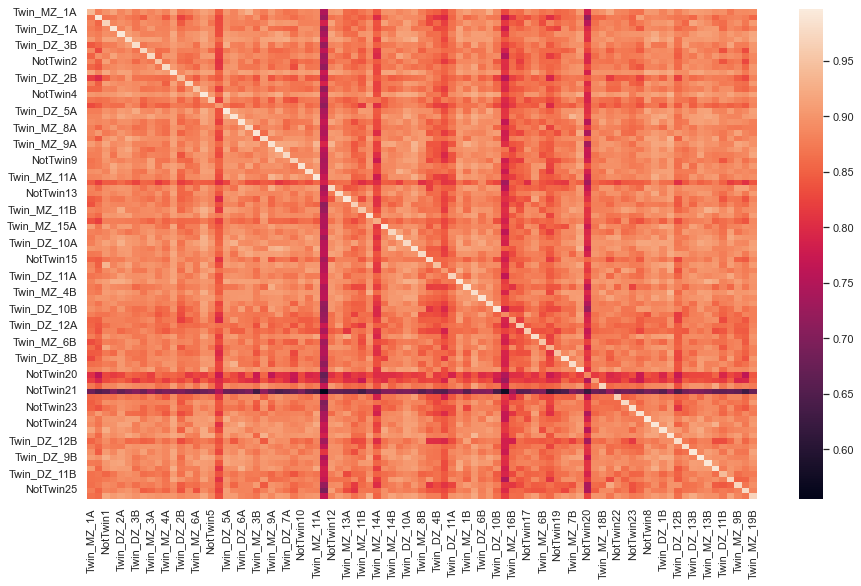

In [41]:
corr_subjects = corr_multi_subjects(record_A, record_B)

In [42]:
corr_subjects.head(15)

,Twin_MZ_1A,Twin_MZ_2A,NotTwin1,Twin_DZ_1A,Twin_DZ_2A,Twin_DZ_3A,Twin_DZ_3B,Twin_DZ_4A,Twin_MZ_3A,NotTwin2,...,Twin_MZ_5B,Twin_DZ_13B,Twin_DZ_9B,Twin_MZ_13B,Twin_MZ_17B,Twin_DZ_11B,Twin_DZ_5B,Twin_MZ_9B,NotTwin25,Twin_MZ_19B
Twin_MZ_1A,0.937043,0.878181,0.898246,0.915192,0.884776,0.901605,0.875185,0.895267,0.883896,0.897317,...,0.898263,0.908891,0.906863,0.901818,0.892755,0.894994,0.869123,0.889997,0.889032,0.892632
Twin_MZ_2A,0.867015,0.993311,0.868310,0.872361,0.887114,0.872533,0.865609,0.848189,0.887924,0.880151,...,0.871569,0.856566,0.894506,0.879421,0.853059,0.874139,0.880414,0.883635,0.877176,0.855810
NotTwin1,0.882675,0.855273,0.967627,0.884710,0.895348,0.887703,0.870375,0.895492,0.886810,0.885670,...,0.856839,0.918566,0.904892,0.892988,0.868542,0.861165,0.887154,0.897934,0.872369,0.905404
Twin_DZ_1A,0.874650,0.863623,0.887394,0.990847,0.881354,0.904016,0.870782,0.883823,0.904207,0.880796,...,0.869404,0.872271,0.897546,0.904076,0.906498,0.857676,0.886756,0.878265,0.861988,0.882188
Twin_DZ_2A,0.882605,0.875695,0.894687,0.889437,0.991398,0.909363,0.896924,0.879989,0.880566,0.885554,...,0.879972,0.902780,0.913198,0.912104,0.903787,0.888445,0.905305,0.894457,0.902859,0.918251
Twin_DZ_3A,0.903657,0.880238,0.915169,0.915529,0.897566,0.978793,0.911603,0.909743,0.911260,0.907033,...,0.906206,0.903979,0.902475,0.905448,0.903382,0.888858,0.895671,0.911106,0.897213,0.920741
Twin_DZ_3B,0.843223,0.855759,0.875635,0.877060,0.894364,0.908755,0.981843,0.869275,0.883539,0.885994,...,0.912246,0.884685,0.879907,0.886399,0.869923,0.883939,0.916902,0.877271,0.874973,0.900664
Twin_DZ_4A,0.887746,0.828135,0.893851,0.886074,0.877436,0.889276,0.868878,0.973437,0.897664,0.861431,...,0.884418,0.906645,0.883047,0.873247,0.878987,0.836174,0.880003,0.867427,0.830704,0.899912
Twin_MZ_3A,0.851767,0.895072,0.882567,0.914317,0.892992,0.895134,0.884241,0.872849,0.977431,0.858189,...,0.884126,0.871544,0.898597,0.880816,0.903193,0.886152,0.893344,0.886784,0.863126,0.886902
NotTwin2,0.881425,0.849980,0.908910,0.875178,0.890767,0.884891,0.857202,0.880079,0.871478,0.952659,...,0.880450,0.893836,0.890545,0.891359,0.873589,0.838824,0.867007,0.873638,0.827639,0.884679


In [43]:
# Maybe modif to take into account corr_df instead of corr_matrix

def top_correlated_subj(corr_matrix, subject_id, nb_top = 3):
    """
    Indicate the top nb_top individuals correlated to the subject (given by suject_id).
    Furthermore, it indicates the link between each participant of the top and the studied subject.
    """
    
    num_row = subject_id_to_row[subject_id] 
    top = corr_matrix.argsort()[num_row][::-1][:nb_top]
    top = top.reshape(-1, 1)
    top = np.apply_along_axis(lambda x : subjects_row_to_id[x[0]], axis = 1, arr = top)

    relations = {}
    for subject in top :
        if subject == subject_id :
            relations[subject] = "Same Subject"
        else : 
            for dict_relation_subj in twins_dict.values():
                if subject_id in dict_relation_subj['subjects']:
                    if subject in dict_relation_subj['subjects']:
                        relations[subject] = dict_relation_subj['type']
                    else : 
                        relations[subject] = "No Link"
                    break

    print("The top {} correlated to subject {} are :".format(nb_top, subject_id))
    for i in range(nb_top):
        print("Rank {} : Subject {} - Relation to the subject : {} ".format(i+1, top[i], relations[top[i]]))

top_correlated_subj(corr_subjects.to_numpy(), 102816, nb_top=5)

The top 5 correlated to subject 102816 are :
Rank 1 : Subject 102816 - Relation to the subject : Same Subject 
Rank 2 : Subject 680957 - Relation to the subject : MZ 
Rank 3 : Subject 153732 - Relation to the subject : No Link 
Rank 4 : Subject 166438 - Relation to the subject : No Link 
Rank 5 : Subject 205119 - Relation to the subject : No Link 


### Using Log scaling

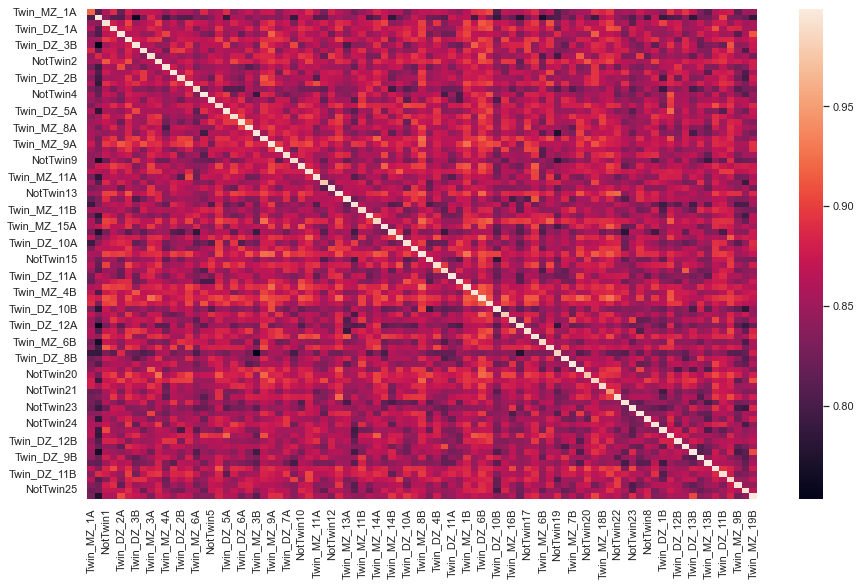

In [44]:
# As the differents frequency bands of the PSD are in differents scales, we try to logscale it
corr_subjects_log = corr_multi_subjects(np.log(record_A), np.log(record_B))

In [45]:
top_correlated_subj(corr_subjects_log.to_numpy(), 102816, nb_top=5)

The top 5 correlated to subject 102816 are :
Rank 1 : Subject 102816 - Relation to the subject : Same Subject 
Rank 2 : Subject 891667 - Relation to the subject : No Link 
Rank 3 : Subject 113922 - Relation to the subject : No Link 
Rank 4 : Subject 248339 - Relation to the subject : No Link 
Rank 5 : Subject 212823 - Relation to the subject : No Link 


**COMMENT :** According to some tests, the log scale version gives a worse accuracy on the prediction of the MZ Twin. It is to be confirmed.
As the log scale gives more importance to the high frequency bands, in the Pearson correlation, we may hypothetize that High Frequency bands don't enable to predict the twin.

We may also try a log log scale ...

## Comparaison correlations between classes of Twins

### Autocorrelation vs Cross-Correlation

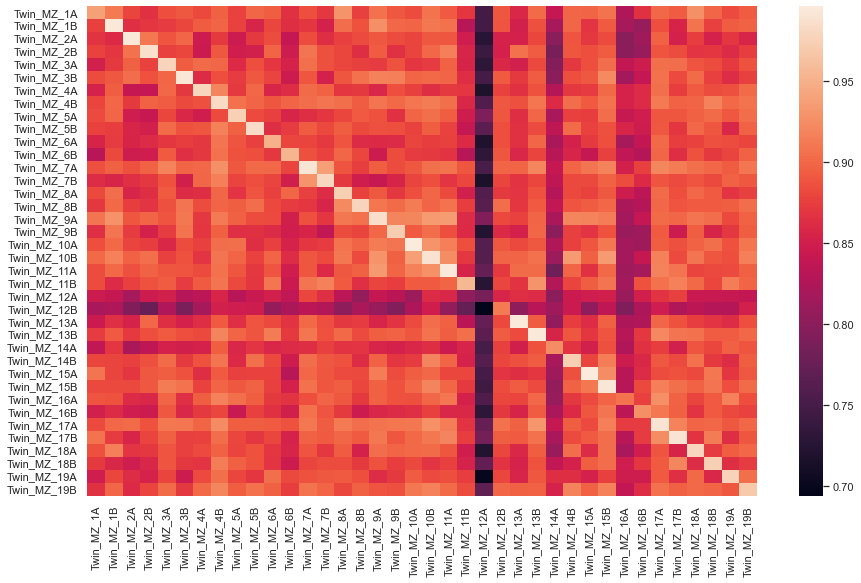

In [46]:
# Correlations between the MZ twins

mask_MZ = [True if subj_id in ids_MZ else False for subj_id in record_A.index]
record_A_MZ = record_A[mask_MZ].reindex(ids_MZ)
record_B_MZ = record_B[mask_MZ].reindex(ids_MZ)

corr_MZ = corr_multi_subjects(record_A_MZ, record_B_MZ)

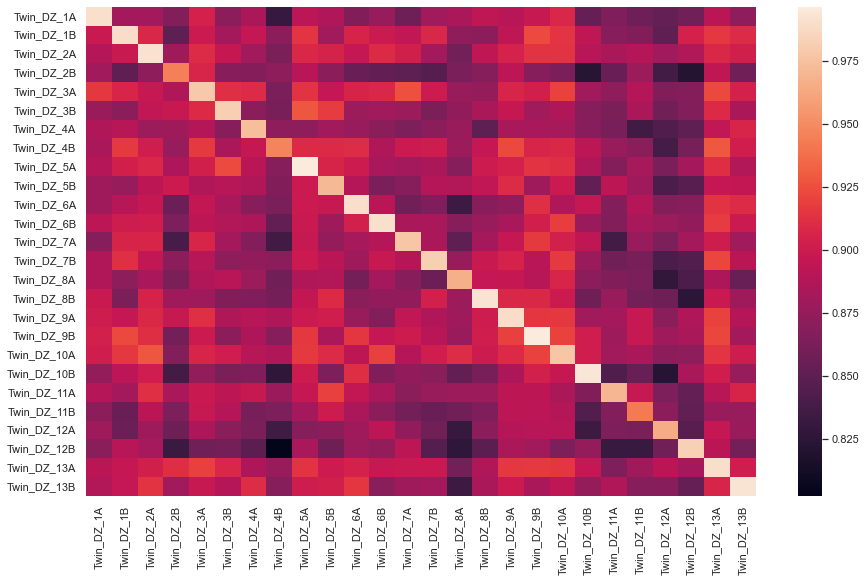

In [47]:
# Correlations between the DZ twins

mask_DZ = [True if subj_id in ids_DZ else False for subj_id in record_A.index]
record_A_DZ = record_A[mask_DZ].reindex(ids_DZ)
record_B_DZ = record_B[mask_DZ].reindex(ids_DZ)

corr_DZ = corr_multi_subjects(record_A_DZ, record_B_DZ)

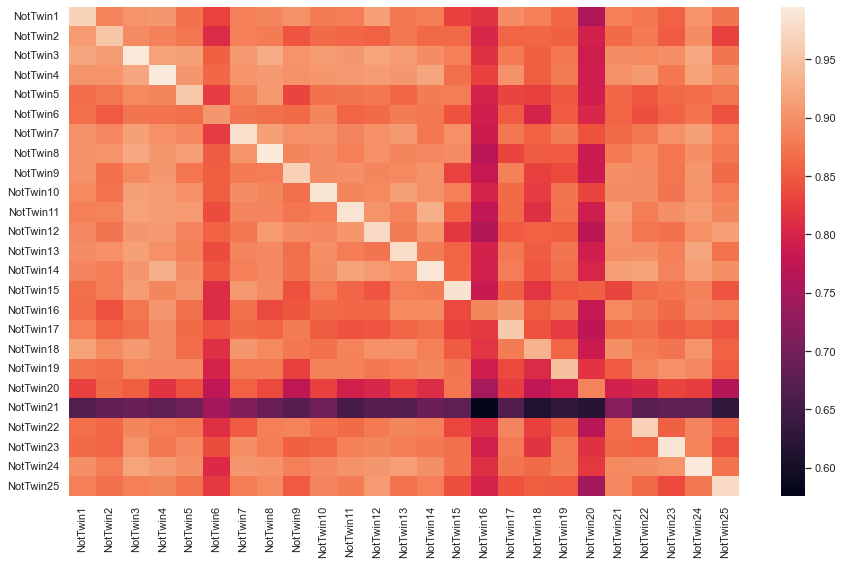

In [48]:
# Correlations between the other unrelated subjects (except one pair of siblings)

mask_NT = [True if subj_id in ids_NT else False for subj_id in record_A.index]
record_A_NT = record_A[mask_NT].reindex(ids_NT)
record_B_NT = record_B[mask_NT].reindex(ids_NT)

corr_NT = corr_multi_subjects(record_A_NT, record_B_NT)

**First result :** Correlations between MZ twins compared to with other participants seem higher than with DZ Twins, which seem to have similar results as uncorrelated people. 

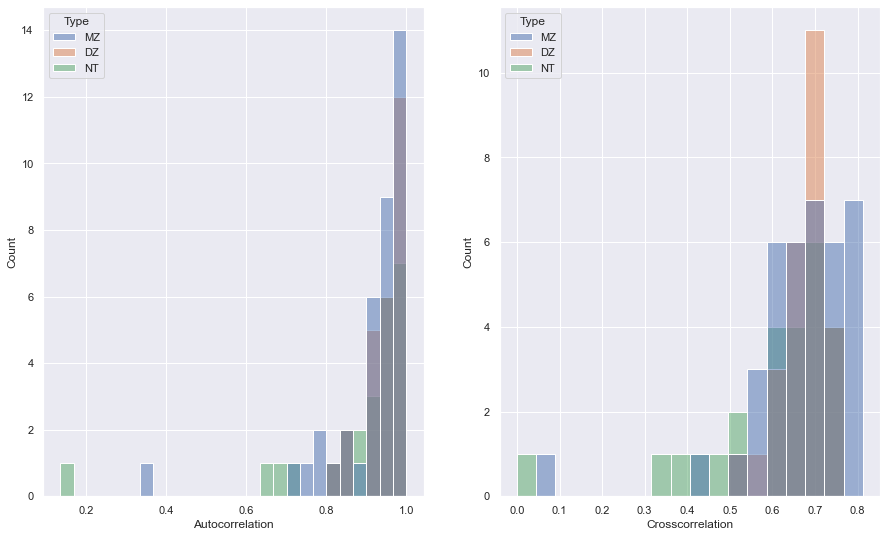

In [49]:
def plot_autocorr_vs_crosscorr(corr_MZ, corr_DZ, corr_NT):
    """
    Given the correlation matrices between:
    - MZ twins (ordered by pairs)
    - DZ twins (also ordered by pair)
    - NotTwins,
    it plots the histogram of the autocorrelation and crosscorrelation (twin A with twin B) for each category.
    The cross correlation for NT is just the correlation between two different subjects.

    ISSUE : Values being too close for the seaborn plot, correlation scores have to be normalized ...
    """
    # Autocorrelations
    autocorr_MZ = corr_MZ.to_numpy().diagonal()
    autocorr_DZ = corr_DZ.to_numpy().diagonal()
    autocorr_NT = corr_NT.to_numpy().diagonal()

    autocorr = np.concatenate([autocorr_MZ, autocorr_DZ, autocorr_NT])

    # Cross-correlations
    # [i, i+1] because pairs come together
    cross_corr_MZ = np.concatenate([[corr_MZ.to_numpy()[i, i+1], corr_MZ.to_numpy()[i+1, i]] for i in range(0, len(corr_MZ), 2)])
    cross_corr_DZ = np.concatenate([[corr_DZ.to_numpy()[i, i+1], corr_DZ.to_numpy()[i+1, i]] for i in range(0, len(corr_DZ), 2)])
    cross_corr_NT = np.concatenate([[corr_NT.to_numpy()[i, i+1], corr_NT.to_numpy()[i+1, i]] for i in range(0, len(corr_NT)//2 * 2, 2)])
    if len(corr_NT) % 2 != 0:
        cross_corr_NT = np.concatenate([cross_corr_NT, [corr_NT.to_numpy()[-1, -2]]]) 

    cross_corr = np.concatenate([cross_corr_MZ, cross_corr_DZ, cross_corr_NT])

    # Additional information
    ids = np.concatenate([ids_MZ, ids_DZ, ids_NT])
    type = np.concatenate([["MZ"] * len(ids_MZ), ["DZ"] * len(ids_DZ), ["NT"] * len(ids_NT) ])

    # Creation of the dataframe containing all the information
    df_eval = np.array([autocorr, cross_corr, type]).T
    df_eval = pd.DataFrame(df_eval, index = ids, columns=["Autocorrelation", "Crosscorrelation", "Type"])

    # PB else seaborn histplot if values are too close ... ==> Normalization
    scaler = MinMaxScaler()
    scaler.fit(np.concatenate([df_eval["Autocorrelation"], df_eval["Crosscorrelation"]]).reshape(-1,1))
    df_eval["Autocorrelation"] = scaler.transform(df_eval["Autocorrelation"].to_numpy().reshape(-1, 1))
    df_eval["Crosscorrelation"] = scaler.transform(df_eval["Crosscorrelation"].to_numpy().reshape(-1, 1))

    # Final Plot
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols= 2, figsize = (15, 9))
    sns.histplot(data = df_eval, x = "Autocorrelation", hue = "Type", ax = ax0)
    sns.histplot(data = df_eval, x = "Crosscorrelation", hue = "Type", ax = ax1)
    plt.show()

plot_autocorr_vs_crosscorr(corr_MZ, corr_DZ, corr_NT)

### Predictions

For the moment, the model used for the prediction takes the best correlation to find the same person, and the second one to match the twin.

In [50]:
def eval_accuracy(corr_df):
    """
    Using the correlation dataframe, it computes the accuracy for the fingerprint prediction, for the MZ twin prediction and for the DZ twin prediction.
    """

    # Autocorrelation accuracy
    nb_true_pred = corr_df.to_numpy().argmax(axis = 0) == np.arange(len(corr_df))
    nb_true_pred = np.count_nonzero(nb_true_pred)
    auto_accuracy = nb_true_pred/len(corr_df)


    # Crosscorrelation accuracy MZ
    mask_MZ = [True if subj_id in ids_MZ else False for subj_id in record_A.index]
    corr_df_rows_MZ = corr_df[mask_MZ]

    second_best_corr = corr_df_rows_MZ.to_numpy().argsort(axis = 1)[:, ::-1][:, 1]
    nb_true_pred = []
    for i, num_column in enumerate(second_best_corr):
        match = re.search("Twin_MZ_[0-9]+(A|B)", corr_df_rows_MZ.index[i]).group(0)
        if corr_df.columns[num_column][:-1] == match[:-1] and match[-1] != corr_df.columns[num_column][-1]:
            nb_true_pred.append(True)
        else:
            nb_true_pred.append(False)
    nb_true_pred = np.count_nonzero(nb_true_pred)
    cross_accuracy_MZ = nb_true_pred/len(corr_df_rows_MZ)


    # Crosscorrelation accuracy DZ
    mask_DZ = [True if subj_id in ids_DZ else False for subj_id in record_A.index]
    corr_df_rows_DZ = corr_df[mask_DZ]

    second_best_corr = corr_df_rows_DZ.to_numpy().argsort(axis = 1)[:, ::-1][:, 1]
    nb_true_pred = []
    for i, num_column in enumerate(second_best_corr):
        match = re.search("Twin_DZ_[0-9]+(A|B)", corr_df_rows_DZ.index[i]).group(0)
        if corr_df.columns[num_column][:-1] == match[:-1] and match[-1] != corr_df.columns[num_column][-1]:
            nb_true_pred.append(True)
        else:
            nb_true_pred.append(False)
    nb_true_pred = np.count_nonzero(nb_true_pred)
    cross_accuracy_DZ = nb_true_pred/len(corr_df_rows_DZ)
    
    return auto_accuracy, cross_accuracy_MZ, cross_accuracy_DZ

auto_acc, cross_MZ_acc, cross_DZ_acc = eval_accuracy(corr_subjects)
print("Accuracy fingerprint : ", auto_acc)
print("Accuracy prediction for MZ twin : ", cross_MZ_acc)
print("Accuracy prediction for DZ twin : ", cross_DZ_acc)


Accuracy fingerprint :  0.9775280898876404
Accuracy prediction for MZ twin :  0.18421052631578946
Accuracy prediction for DZ twin :  0.0


## Correlations per ROI

In [51]:
# List of the names of the different Regions in the used Atlas
list_ROI = list(set([c.replace(re.search("_[0-9]+\.[0-9]*", c).group(0), "") for c in record_A.columns]))
len(list_ROI)

148

In [52]:
# Compute accuracies for predictions made for each ROI

df = []

corr_subjects = corr_multi_subjects(record_A, record_B, plot = False)
auto_acc, cross_MZ_acc, cross_DZ_acc = eval_accuracy(corr_subjects)
df.append([auto_acc, cross_MZ_acc, cross_DZ_acc])

for ROI in tqdm(list_ROI, total = len(list_ROI))  :
    columns_ROI = [c for c in record_A.columns if re.match(ROI, c)]
    record_A_ROI = record_A[columns_ROI]
    record_B_ROI = record_B[columns_ROI]

    corr_subjects_ROI = corr_multi_subjects(record_A_ROI, record_B_ROI, plot = False)

    auto_acc, cross_MZ_acc, cross_DZ_acc = eval_accuracy(corr_subjects_ROI)
    df.append([auto_acc, cross_MZ_acc, cross_DZ_acc])

df = pd.DataFrame(df, index=["Full_brain"] + list_ROI, columns=["Acc Autocorr", "Acc Crosscorr MZ", "Acc Crosscorr DZ"])
df.head(10)

100%|██████████| 148/148 [03:31<00:00,  1.43s/it]


,Acc Autocorr,Acc Crosscorr MZ,Acc Crosscorr DZ
Full_brain,0.977528,0.184211,0.000000
G_cingul-Post-ventral R,0.011236,0.000000,0.000000
G_pariet_inf-Supramar L,0.044944,0.052632,0.000000
G_insular_short R,0.078652,0.000000,0.000000
S_circular_insula_inf L,0.044944,0.000000,0.000000
G_precuneus R,0.044944,0.026316,0.000000
S_occipital_ant R,0.011236,0.026316,0.038462
G_and_S_cingul-Mid-Post R,0.056180,0.000000,0.038462
G_cingul-Post-ventral L,0.033708,0.000000,0.000000
Pole_occipital L,0.056180,0.052632,0.000000


In [53]:
df_ROI = df.copy()

In [54]:
df_ROI.sort_values(by = "Acc Crosscorr MZ", ascending=False).iloc[:10].head()

,Acc Autocorr,Acc Crosscorr MZ,Acc Crosscorr DZ
Full_brain,0.977528,0.184211,0.000000
S_interm_prim-Jensen R,0.022472,0.105263,0.038462
G_front_inf-Opercular R,0.033708,0.078947,0.000000
G_rectus R,0.033708,0.078947,0.000000
S_oc_sup_and_transversal R,0.056180,0.078947,0.000000


<AxesSubplot:>

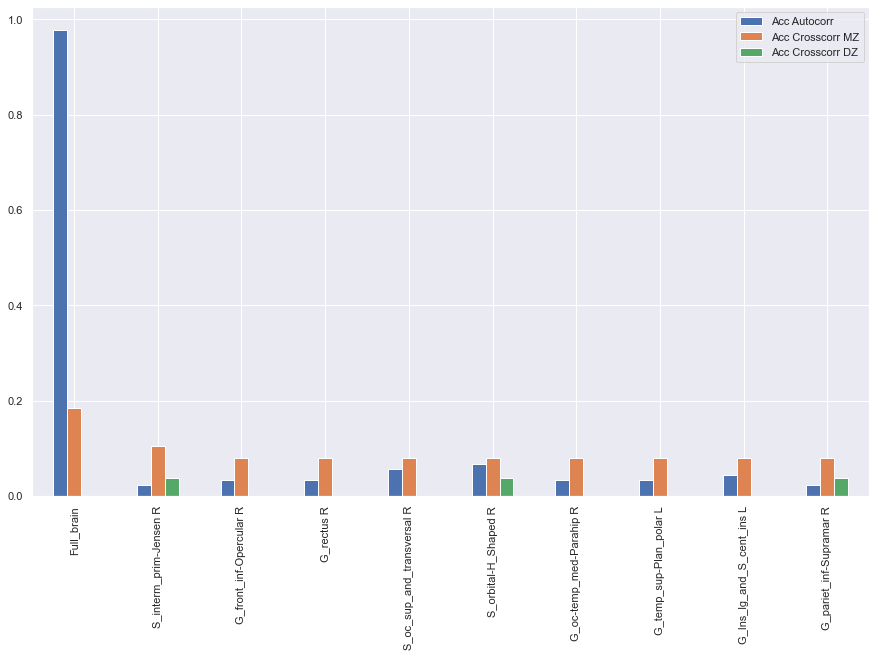

In [55]:
df_ROI.sort_values(by = "Acc Crosscorr MZ", ascending=False).iloc[:10].plot(kind = 'bar', figsize = (15, 9))

<AxesSubplot:>

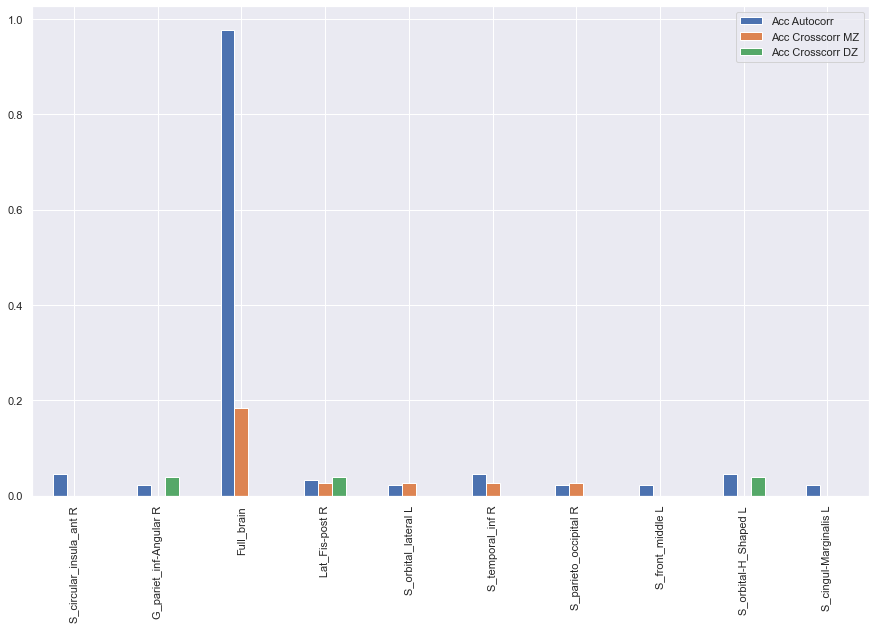

In [56]:
df_ROI.sample(n = 10).plot(kind = 'bar', figsize = (15, 9))

In [23]:
# Correlation 1 vs 1 per ROI

In [24]:
# Use different methods to convert this 1v1 matrix to one value :
# Mean of everything, mean on the diagonal, max everything, max diagonal, selection of one of multiple elements of the matrix

## Correlations per Frequency Band

### Study on one band

In [57]:
# Choose band here : 
band = ALPHA

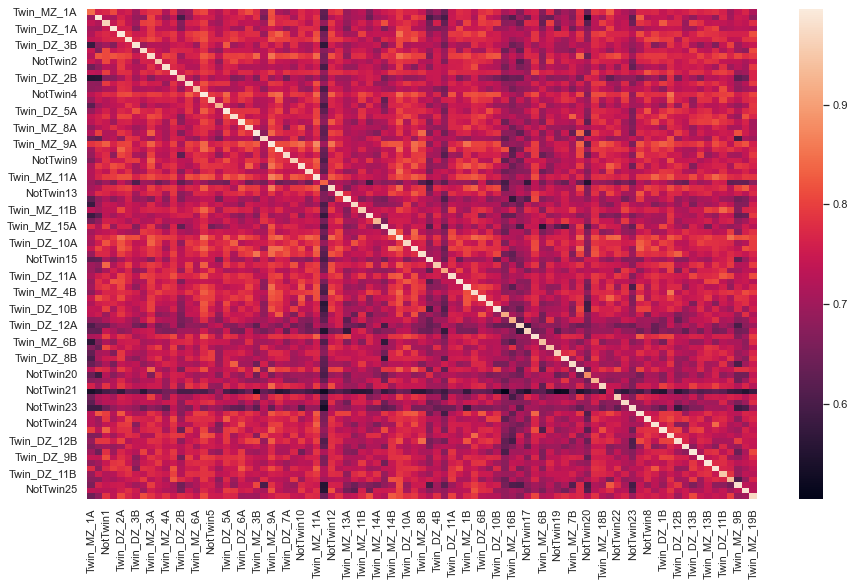

In [58]:
# Correlations between subjects based only on this frequency band

columns_band_freq = [c for c in record_A.columns if float(re.search("[0-9]+\.[0-9]*", c).group(0)) >= band[0] and float(re.search("[0-9]+\.[0-9]*", c).group(0)) <= band[1]]
record_A_band_freq = record_A[columns_band_freq]
record_B_band_freq = record_B[columns_band_freq]

corr_subjects_band_freq = corr_multi_subjects(record_A_band_freq, record_B_band_freq)

In [59]:
top_correlated_subj(corr_subjects_band_freq.to_numpy(), 102816, nb_top=5)

The top 5 correlated to subject 102816 are :
Rank 1 : Subject 102816 - Relation to the subject : Same Subject 
Rank 2 : Subject 680957 - Relation to the subject : MZ 
Rank 3 : Subject 172029 - Relation to the subject : No Link 
Rank 4 : Subject 113922 - Relation to the subject : No Link 
Rank 5 : Subject 283543 - Relation to the subject : No Link 


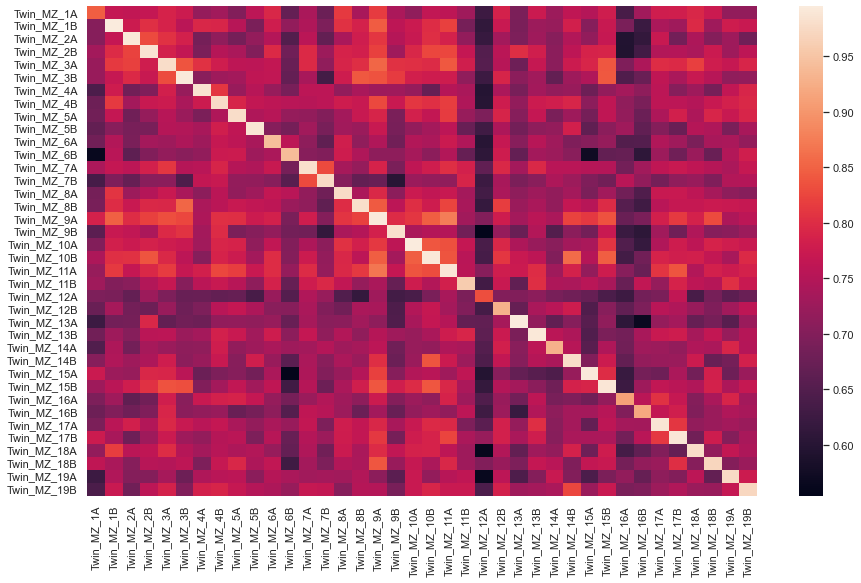

In [60]:
# Correlations between MZ subjects based only on this frequency band

mask_MZ = [True if subj_id in ids_MZ else False for subj_id in record_A.index]
record_A_MZ_band_freq = record_A_band_freq[mask_MZ].reindex(ids_MZ)
record_B_MZ_band_freq = record_B_band_freq[mask_MZ].reindex(ids_MZ)

corr_MZ_band_freq = corr_multi_subjects(record_A_MZ_band_freq, record_B_MZ_band_freq)

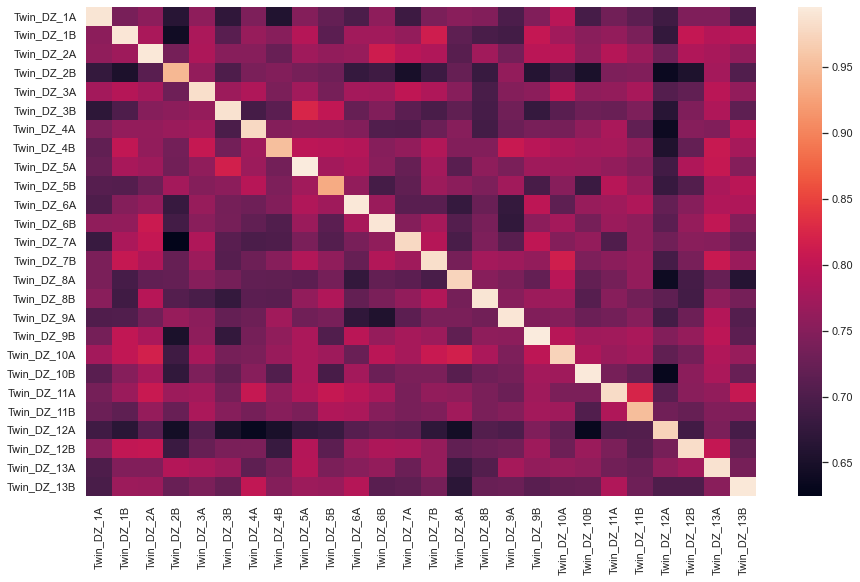

In [61]:
# Correlations between DZ subjects based only on this frequency band

mask_DZ = [True if subj_id in ids_DZ else False for subj_id in record_A.index]
record_A_DZ_band_freq = record_A_band_freq[mask_DZ].reindex(ids_DZ)
record_B_DZ_band_freq = record_B_band_freq[mask_DZ].reindex(ids_DZ)

corr_DZ_band_freq = corr_multi_subjects(record_A_DZ_band_freq, record_B_DZ_band_freq)

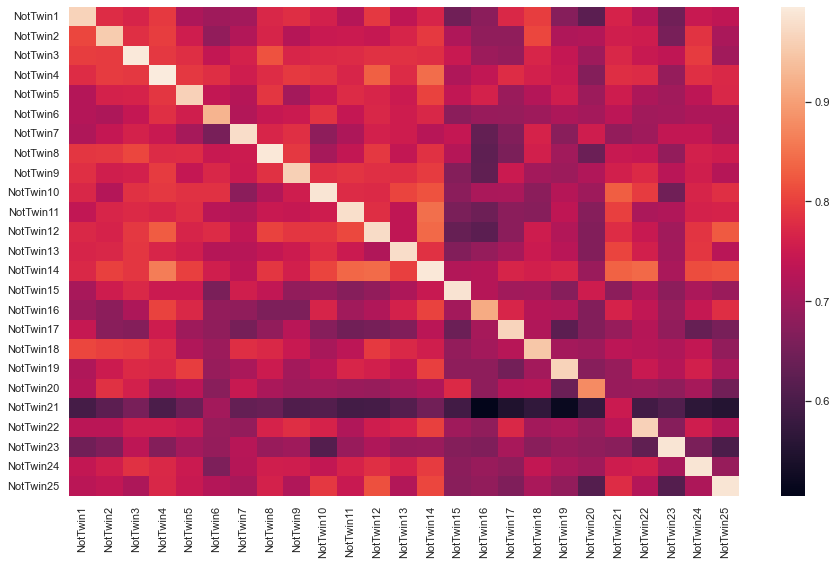

In [62]:
# Correlations between NT subjects based only on this frequency band

mask_NT = [True if subj_id in ids_NT else False for subj_id in record_A.index]
record_A_NT_band_freq = record_A_band_freq[mask_NT].reindex(ids_NT)
record_B_NT_band_freq = record_B_band_freq[mask_NT].reindex(ids_NT)

corr_NT_band_freq = corr_multi_subjects(record_A_NT_band_freq, record_B_NT_band_freq)

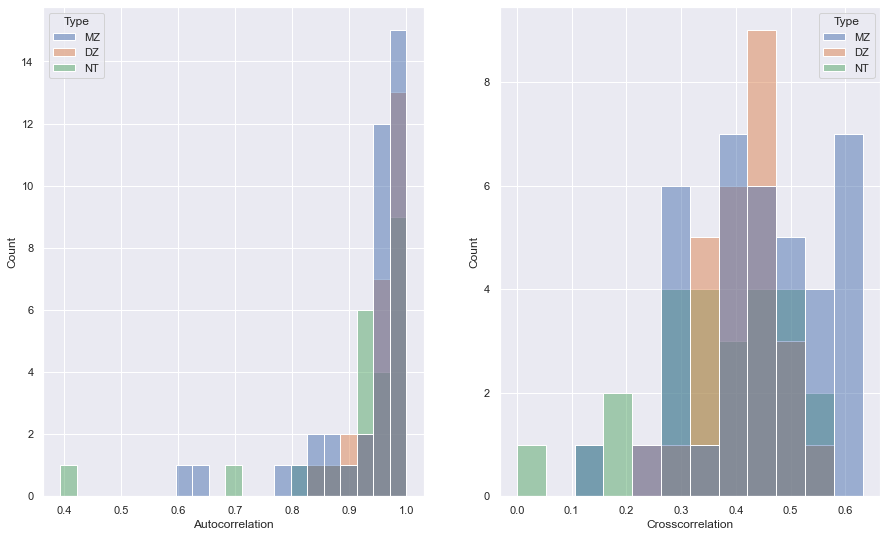

In [63]:
plot_autocorr_vs_crosscorr(corr_MZ=corr_MZ_band_freq, corr_DZ=corr_DZ_band_freq, corr_NT=corr_NT_band_freq)

#### Predictions

In [64]:
auto_acc, cross_MZ_acc, cross_DZ_acc = eval_accuracy(corr_subjects_band_freq)
print("Accuracy fingerprint : ", auto_acc)
print("Accuracy prediction for MZ twin : ", cross_MZ_acc)
print("Accuracy prediction for DZ twin : ", cross_DZ_acc)

Accuracy fingerprint :  0.9887640449438202
Accuracy prediction for MZ twin :  0.10526315789473684
Accuracy prediction for DZ twin :  0.0


### Comparaison results on different bands

#### Accuracy predictions

In [65]:
df = []

for band in [BROADBAND, DELTA, THETA, ALPHA, BETA, GAMMA, HIGH_GAMMA] :
    columns_band_freq = [c for c in record_A.columns if float(re.search("[0-9]+\.[0-9]*", c).group(0)) >= band[0] and float(re.search("[0-9]+\.[0-9]*", c).group(0)) <= band[1]]
    record_A_band_freq = record_A[columns_band_freq]
    record_B_band_freq = record_B[columns_band_freq]

    corr_subjects_band_freq = corr_multi_subjects(record_A_band_freq, record_B_band_freq, plot = False)

    auto_acc, cross_MZ_acc, cross_DZ_acc = eval_accuracy(corr_subjects_band_freq)
    df.append([auto_acc, cross_MZ_acc, cross_DZ_acc])

df = pd.DataFrame(df, index=["Broadband", "Delta", "Theta", "Alpha", "Beta", "Gamma", "High Gamma"], columns=["Acc Autocorr", "Acc Crosscorr MZ", "Acc Crosscorr DZ"])
df.head(7)

,Acc Autocorr,Acc Crosscorr MZ,Acc Crosscorr DZ
Broadband,0.977528,0.184211,0.0
Delta,0.977528,0.210526,0.0
Theta,0.988764,0.131579,0.0
Alpha,0.988764,0.105263,0.0
Beta,1.000000,0.105263,0.0
Gamma,1.000000,0.105263,0.0
High Gamma,1.000000,0.105263,0.0


<AxesSubplot:>

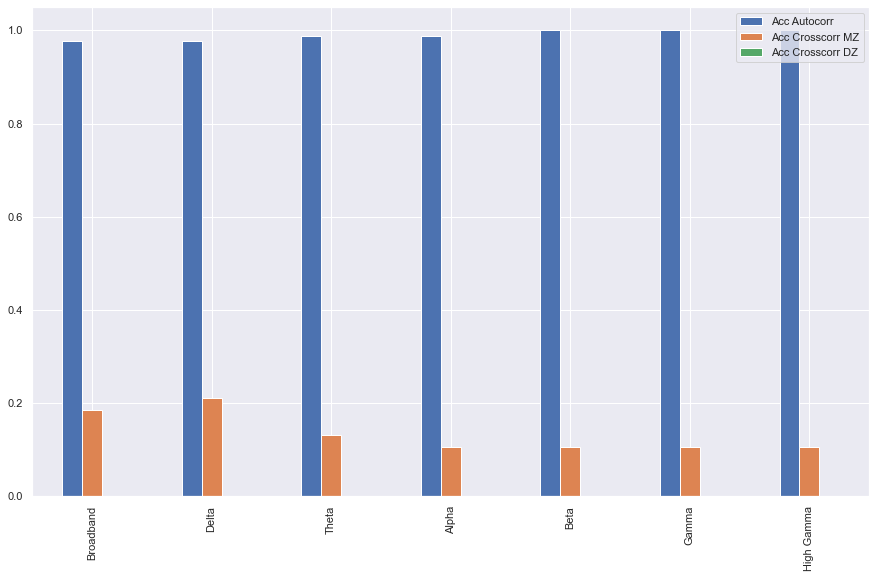

In [66]:
df.plot(kind = 'bar', figsize = (15, 9))

#### Comparing correlations

In [75]:
def eval_correlations(corr_MZ, corr_DZ, corr_NT):
    """
    Note : corr_MZ and corr_DZ have to be ordered such that twins always are one next to each other
    """
    
    # Autocorrelation
    autocorr_MZ = corr_MZ.to_numpy().diagonal()
    autocorr_DZ = corr_DZ.to_numpy().diagonal()
    autocorr_NT = corr_NT.to_numpy().diagonal()

    autocorr = np.concatenate([autocorr_MZ, autocorr_DZ, autocorr_NT])
    autocorr_moy = np.mean(autocorr)
    autocorr_std = np.std(autocorr)

    # Cross correlation
    cross_corr_MZ = np.concatenate([[corr_MZ.to_numpy()[i, i+1], corr_MZ.to_numpy()[i+1, i]] for i in range(0, len(corr_MZ), 2)])
    cross_corr_DZ = np.concatenate([[corr_DZ.to_numpy()[i, i+1], corr_DZ.to_numpy()[i+1, i]] for i in range(0, len(corr_DZ), 2)])
    cross_corr_NT = np.concatenate([[corr_NT.to_numpy()[i, i+1], corr_NT.to_numpy()[i+1, i]] for i in range(0, len(corr_NT)//2 * 2, 2)])
    if len(corr_NT) % 2 != 0:
        cross_corr_NT = np.concatenate([cross_corr_NT, [corr_NT.to_numpy()[-1, -2]]]) 

    cross_corr_MZ_moy = np.mean(cross_corr_MZ)
    cross_corr_MZ_std = np.std(cross_corr_MZ)
    cross_corr_DZ_moy = np.mean(cross_corr_DZ)
    cross_corr_DZ_std = np.std(cross_corr_DZ)
    cross_corr_NT_moy = np.mean(cross_corr_NT)
    cross_corr_NT_std = np.std(cross_corr_NT)

    print(cross_corr_NT_moy)

    return autocorr_moy, cross_corr_MZ_moy, cross_corr_DZ_moy, cross_corr_NT_moy, autocorr_std, cross_corr_MZ_std, cross_corr_DZ_std, cross_corr_NT_std


In [76]:
bands = [BROADBAND, DELTA, THETA, ALPHA, BETA, GAMMA, HIGH_GAMMA]
bands_names = ["BROADBAND", "DELTA", "THETA", "ALPHA", "BETA", "GAMMA", "HIGH_GAMMA"]
df = []

for band in tqdm(bands, total = len(bands)) :
    # MZ
    columns_band_freq = [c for c in record_A.columns if float(re.search("[0-9]+\.[0-9]*", c).group(0)) >= band[0] and float(re.search("[0-9]+\.[0-9]*", c).group(0)) <= band[1]]
    record_A_band_freq = record_A[columns_band_freq]
    record_B_band_freq = record_B[columns_band_freq]
    
    mask_MZ = [True if subj_id in ids_MZ else False for subj_id in record_A.index]
    record_A_MZ_band_freq = record_A_band_freq[mask_MZ].reindex(ids_MZ)
    record_B_MZ_band_freq = record_B_band_freq[mask_MZ].reindex(ids_MZ)

    corr_MZ_band_freq = corr_multi_subjects(record_A_MZ_band_freq, record_B_MZ_band_freq, plot = False)

    # DZ
    columns_band_freq = [c for c in record_A.columns if float(re.search("[0-9]+\.[0-9]*", c).group(0)) >= band[0] and float(re.search("[0-9]+\.[0-9]*", c).group(0)) <= band[1]]
    record_A_band_freq = record_A[columns_band_freq]
    record_B_band_freq = record_B[columns_band_freq]
    
    mask_DZ = [True if subj_id in ids_DZ else False for subj_id in record_A.index]
    record_A_DZ_band_freq = record_A_band_freq[mask_DZ].reindex(ids_DZ)
    record_B_DZ_band_freq = record_B_band_freq[mask_DZ].reindex(ids_DZ)

    corr_DZ_band_freq = corr_multi_subjects(record_A_DZ_band_freq, record_B_DZ_band_freq, plot = False)

    # NT
    columns_band_freq = [c for c in record_A.columns if float(re.search("[0-9]+\.[0-9]*", c).group(0)) >= band[0] and float(re.search("[0-9]+\.[0-9]*", c).group(0)) <= band[1]]
    record_A_band_freq = record_A[columns_band_freq]
    record_B_band_freq = record_B[columns_band_freq]
    
    mask_NT = [True if subj_id in ids_NT else False for subj_id in record_A.index]
    record_A_NT_band_freq = record_A_band_freq[mask_NT].reindex(ids_NT)
    record_B_NT_band_freq = record_B_band_freq[mask_NT].reindex(ids_NT)

    corr_NT_band_freq = corr_multi_subjects(record_A_NT_band_freq, record_B_NT_band_freq, plot = False)

    # Final
    autocorr_moy, cross_corr_MZ_moy, cross_corr_DZ_moy, cross_corr_NT_moy, autocorr_std, cross_corr_MZ_std, cross_corr_DZ_std, cross_corr_NT_std  = eval_correlations(corr_MZ_band_freq, corr_DZ_band_freq, corr_NT_band_freq)
    df.append([autocorr_moy, cross_corr_MZ_moy, cross_corr_DZ_moy, cross_corr_NT_moy, autocorr_std, cross_corr_MZ_std, cross_corr_DZ_std, cross_corr_NT_std])

df = pd.DataFrame(df, index=bands_names, columns=["Autocorr", "Crosscorr MZ", "Crosscorr DZ", "Crosscorr NT", "Autocorr std", "Crosscorr MZ std", "Crosscorr DZ std", "Crosscorr NT std"])
df.head()

 14%|█▍        | 1/7 [00:02<00:14,  2.34s/it]

0.8658165186012848


 29%|██▊       | 2/7 [00:03<00:06,  1.36s/it]

0.7624485833492715


 43%|████▎     | 3/7 [00:03<00:04,  1.05s/it]

0.741515943667498


 57%|█████▋    | 4/7 [00:04<00:02,  1.10it/s]

0.7390627567203235


 71%|███████▏  | 5/7 [00:05<00:01,  1.11it/s]

0.7599625668650697


 86%|████████▌ | 6/7 [00:06<00:00,  1.11it/s]

0.7289643452165475


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]

0.7058716099504465


,Autocorr,Crosscorr MZ,Crosscorr DZ,Crosscorr NT,Autocorr std,Crosscorr MZ std,Crosscorr DZ std,Crosscorr NT std
BROADBAND,0.967615,0.888276,0.891449,0.865817,0.041128,0.041887,0.017396,0.053911
DELTA,0.940042,0.799590,0.799108,0.762449,0.066799,0.067941,0.030757,0.083845
THETA,0.956748,0.773484,0.765151,0.741516,0.051246,0.056367,0.026017,0.066330
ALPHA,0.968284,0.769712,0.758018,0.739063,0.037995,0.049570,0.026214,0.054287
BETA,0.979448,0.787593,0.776298,0.759963,0.024293,0.040057,0.025680,0.042758


<AxesSubplot:>

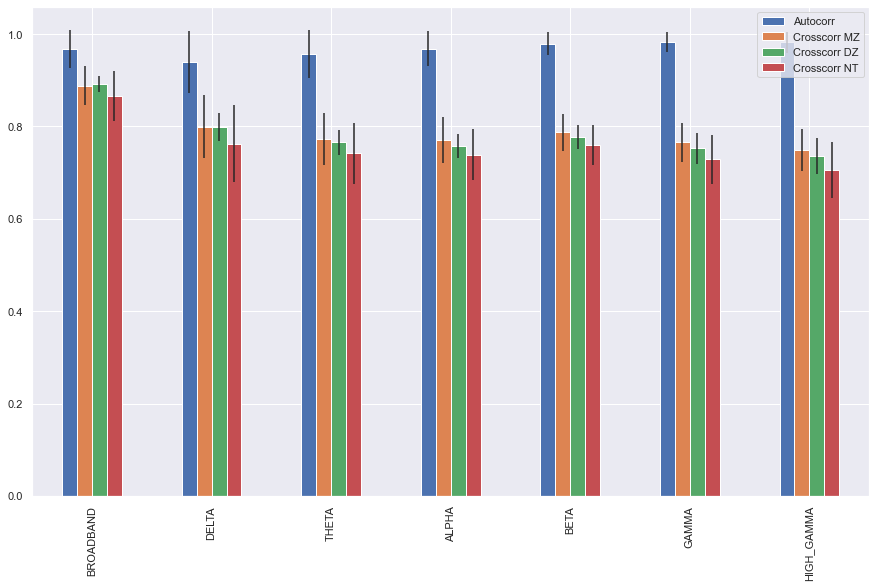

In [77]:
df.plot(kind = 'bar', y = ["Autocorr", "Crosscorr MZ", "Crosscorr DZ", "Crosscorr NT"], yerr=[df["Autocorr std"], df["Crosscorr MZ std"], df["Crosscorr DZ std"], df["Crosscorr NT std"]], figsize = (15, 9))

# Spot Features of Interest (ROI x Time Freq)

## ICC Analysis (features of interest for fingerprint)

## Differention Power Analysis (features of interest for fingerprint)

## New score : high correlation for MZ twins and low correlation for DZ twins

# Heritability Analysis of those features

## First summary of previous results

In [78]:
# Use the more significant previous results

c:\Users\jonat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


[0.23195715 0.05598046]


c:\Users\jonat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\jonat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


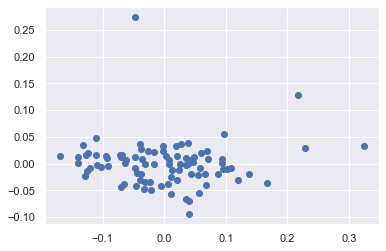

In [79]:
# PCAs or other Dimension Reduction algorithms

# To do way cleaner but meanwhile it seems good !!! I mean ok

pca = PCA(n_components=2)
pca.fit(record_A)
print(pca.explained_variance_ratio_)
plt.scatter(pca.transform(record_A)[:, 0], pca.transform(record_A)[:, 1])

c:\Users\jonat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\jonat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\jonat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\jonat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dty

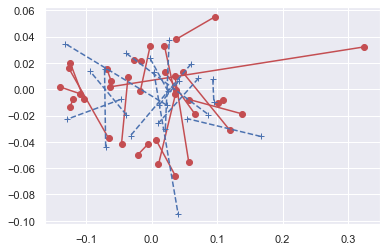

In [80]:
for i in range(0, len(record_A_MZ), 2):
    plt.plot(pca.transform(record_A_MZ)[i:i+2, 0], pca.transform(record_A_MZ)[i:i+2, 1], "ro-")
for i in range(0, len(record_A_DZ), 2):
    plt.plot(pca.transform(record_A_DZ)[i:i+2, 0], pca.transform(record_A_DZ)[i:i+2, 1], "b+--")
plt.show()

c:\Users\jonat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\jonat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\jonat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\jonat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dty

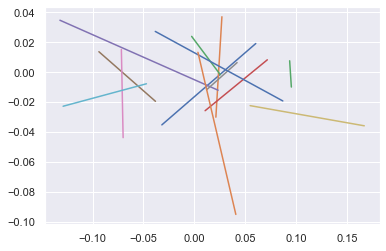

In [81]:
for i in range(0, len(record_A_DZ), 2):
    plt.plot(pca.transform(record_A_DZ)[i:i+2, 0], pca.transform(record_A_DZ)[i:i+2, 1])
plt.show()

c:\Users\jonat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\jonat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


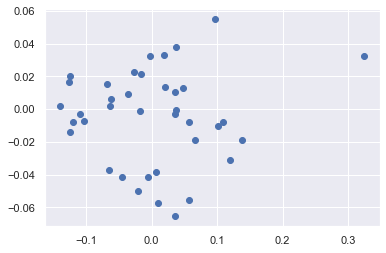

In [82]:
plt.scatter(pca.transform(record_A_MZ)[:, 0], pca.transform(record_A_MZ)[:, 1])

# Correlation between Features of Interest (FOI) and Traits of Interest (TOI) 